<a href="https://colab.research.google.com/github/nupurrana451/Machine-Learning-Projects/blob/main/MBTI_personality_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Importing Dependencies**

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Simplifying The Text

In [7]:
mbti_df=pd.read_csv('mbti_1.csv')

We divide the categories into 4 main features:


1.   I vs E (Introvert vs Extrovert)
2.   N vs S (Sensing vs Intuition)
3. F vs T (Feeling vs Thinking)
4. J vs P (Judging vs Perceiving)



# EDA

In [8]:
mbti_df['I']=np.where(mbti_df['type'].str[0] == 'I',1,0)
mbti_df['N']=np.where(mbti_df['type'].str[1] == 'N',1,0)
mbti_df['F']=np.where(mbti_df['type'].str[2] == 'F',1,0)
mbti_df['P']=np.where(mbti_df['type'].str[3] == 'P',1,0)
mbti_df.head()

,type,posts,I,N,F,P
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,0,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,0,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,0,0
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,0,0


/tmp/ipython-input-9-2126717169.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type',data=mbti_df, palette='coolwarm')


<Axes: xlabel='type', ylabel='count'>

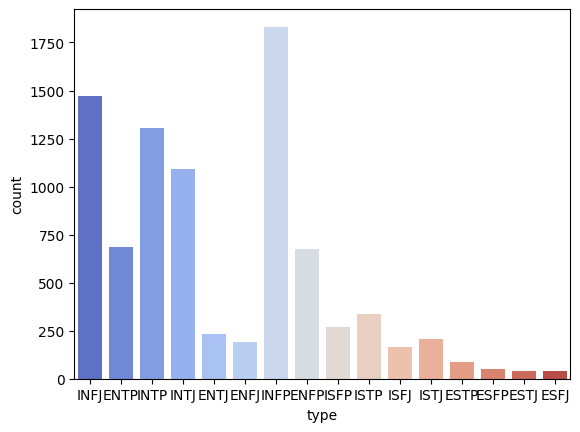

In [9]:
sns.countplot(x='type',data=mbti_df, palette='coolwarm')

/tmp/ipython-input-10-1444028930.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='I',data=mbti_df, ax=axes[0,0],palette='coolwarm').set_title('I vs E')
/tmp/ipython-input-10-1444028930.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='N',data=mbti_df, ax=axes[0,1], palette='coolwarm').set_title('N vs S')
/tmp/ipython-input-10-1444028930.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='F',data=mbti_df, ax=axes[1,0], palette='coolwarm').set_title('F vs T')
/tmp/ipython-input-10-1444028930.py:6: FutureWarning: 

Passing `

Text(0.5, 1.0, 'J vs P')

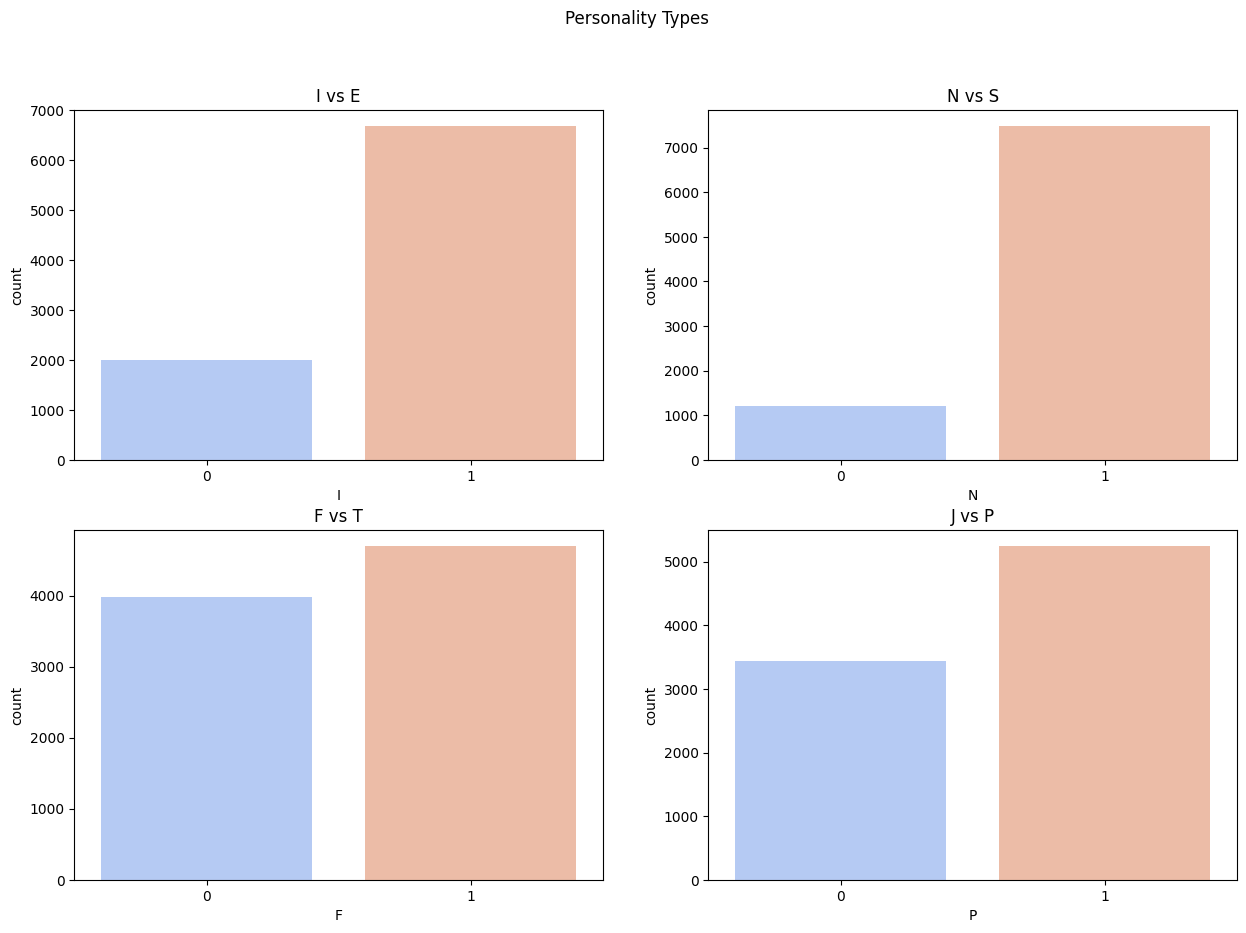

In [10]:
fig,axes=plt.subplots(2,2,figsize=(15,10))
fig.suptitle('Personality Types')
sns.countplot(x='I',data=mbti_df, ax=axes[0,0],palette='coolwarm').set_title('I vs E')
sns.countplot(x='N',data=mbti_df, ax=axes[0,1], palette='coolwarm').set_title('N vs S')
sns.countplot(x='F',data=mbti_df, ax=axes[1,0], palette='coolwarm').set_title('F vs T')
sns.countplot(x='P',data=mbti_df, ax=axes[1,1], palette='coolwarm').set_title('J vs P')

Imbalanced data: accuracy score won't be give us the accurate prediction.

Now, data cleaning and simplifying.

In [11]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lemmatizer=WordNetLemmatizer()
stop_words=set(stopwords.words('english'))
def cleanText(text):
  text=re.sub(r'http\S+|www\S+|https\S+','',text,flags=re.MULTILINE)
  text=re.sub('[^a-zA-Z]',' ',text)
  text=re.sub(r'\|\|\|',' ',text)
  text=text.lower()
  words=[lemmatizer.lemmatize(word) for word in text.split(' ') if word not in stop_words]
  text=' '.join(words)
  return text
mbti_df['cleaned_posts']=mbti_df['posts'].apply(cleanText)


In [12]:
vectorizer=TfidfVectorizer(ngram_range=(1,2),max_features=5000)
mbti_df.head()

,type,posts,I,N,F,P,cleaned_posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,1,1,1,0,intj moment sportscenter top ten play ...
1,ENTP,'I'm finding the lack of me in these posts ver...,0,1,0,1,finding lack post alarming sex boring posi...
2,INTP,'Good one _____ https://www.youtube.com/wat...,1,1,0,1,good one course say know blessing...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",1,1,0,0,dear intp enjoyed conversation day esote...
4,ENTJ,'You're fired.|||That's another silly misconce...,0,1,0,0,fired another silly misconception approac...


In [21]:
from sklearn.metrics import classification_report

X = mbti_df['cleaned_posts']
column_names = ['I', 'N', 'F', 'P']

for col_name in column_names:
    Y = mbti_df[col_name]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

    vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    if col_name == 'I':
        model = svm.SVC(probability=True, class_weight='balanced', C=1)
    else:
        model = LogisticRegression(max_iter=1000, C=1, class_weight='balanced')

    model.fit(X_train_vec, Y_train)
    Y_pred = model.predict(X_test_vec)

    print(f"\nClassification Report for {col_name}:")
    print(classification_report(Y_test, Y_pred))


Classification Report for I:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       397
           1       0.90      0.93      0.92      1338

    accuracy                           0.87      1735
   macro avg       0.82      0.80      0.81      1735
weighted avg       0.87      0.87      0.87      1735


Classification Report for N:
              precision    recall  f1-score   support

           0       0.58      0.76      0.66       252
           1       0.96      0.91      0.93      1483

    accuracy                           0.89      1735
   macro avg       0.77      0.83      0.79      1735
weighted avg       0.90      0.89      0.89      1735


Classification Report for F:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       779
           1       0.90      0.88      0.89       956

    accuracy                           0.88      1735
   macro avg       0.88      0.88     




1.   I vs E: minority class suffers the most, but excellent f1 score for Introvert class.
2.   N vs S: Same as I vs E class.


*   To deal with these results, we'll do the following:
1. Further hyperparameter tuning and compare with XGBooster model. Then, for better evaluation, using stratifiedKFold and finally improvising feature engineering by increasing max_features and ngram.

# I vs E class: Finding the best model

In [14]:
#model classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

# Prepare data
X_I = mbti_df['cleaned_posts']
Y_I = mbti_df['I']
X_train_I, X_test_I, Y_train_I, Y_test_I = train_test_split(X_I, Y_I, test_size=0.2, random_state=3)

# Vectorize text
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_vec_I = vectorizer.fit_transform(X_train_I)
X_test_vec_I = vectorizer.transform(X_test_I)

# Calculate imbalance ratio
counter = Counter(Y_train_I)
class_imbalance_ratio = counter[0] / counter[1]  # Adjust if needed

# Define and train model
model_I2 = XGBClassifier(scale_pos_weight=class_imbalance_ratio, use_label_encoder=False, eval_metric='logloss')
model_I2.fit(X_train_vec_I, Y_train_I)

# Predict
Y_pred_I2 = model_I2.predict(X_test_vec_I)

# Cross-validation F1 score
cv_scores = cross_val_score(model_I2, X_train_vec_I, Y_train_I, cv=StratifiedKFold(5), scoring='f1')
print("CV F1 Score:", cv_scores.mean())
classification_report_I = classification_report(Y_test_I, Y_pred_I2)
print(classification_report_I)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:33:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:34:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:35:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:36:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:37:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

CV F1 Score: 0.9031545622633868
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       397
           1       0.90      0.92      0.91      1338

    accuracy                           0.86      1735
   macro avg       0.80      0.78      0.79      1735
weighted avg       0.85      0.86      0.85      1735



Threshold tuning to improve minority f1 score

In [15]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Get predicted probabilities (for class 1)

Y_probs = model.predict_proba(X_test_vec_I)[:, 1]

# Try different thresholds
thresholds = np.arange(0.3, 0.7, 0.05)
for threshold in thresholds:
    Y_pred_thresh = (Y_probs >= threshold).astype(int)
    f1 = f1_score(Y_test_I, Y_pred_thresh)
    print(f"Threshold: {threshold:.2f} -> F1 Score: {f1:.4f}")


Threshold: 0.30 -> F1 Score: 0.9115
Threshold: 0.35 -> F1 Score: 0.9132
Threshold: 0.40 -> F1 Score: 0.9161
Threshold: 0.45 -> F1 Score: 0.9109
Threshold: 0.50 -> F1 Score: 0.9082
Threshold: 0.55 -> F1 Score: 0.9028
Threshold: 0.60 -> F1 Score: 0.8960
Threshold: 0.65 -> F1 Score: 0.8910


In [16]:
best_thresh=0.40
Y_pred_I2_thresh = (Y_probs >= best_thresh).astype(int)
print(classification_report(Y_test_I, Y_pred_I2_thresh))

              precision    recall  f1-score   support

           0       0.77      0.60      0.67       397
           1       0.89      0.95      0.92      1338

    accuracy                           0.87      1735
   macro avg       0.83      0.77      0.79      1735
weighted avg       0.86      0.87      0.86      1735



Improved precision, and excellent recall for introvert class. However, the f1 score remains the same.

# N vs S: Finding the best model

In [17]:
# Prepare data
X_N = mbti_df['cleaned_posts']
Y_N = mbti_df['N']
X_train_N, X_test_N, Y_train_N, Y_test_N = train_test_split(X_N, Y_N, test_size=0.2, random_state=3)

# Vectorize text
vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=10000)
X_train_vec_N = vectorizer.fit_transform(X_train_N)
X_test_vec_N = vectorizer.transform(X_test_N)

# Calculate imbalance ratio
counter = Counter(Y_train_N)
class_imbalance_ratio = counter[0] / counter[1]  # Adjust if needed

# Define and train model
model_N2 = XGBClassifier(scale_pos_weight=class_imbalance_ratio, use_label_encoder=False, eval_metric='logloss')
model_N2.fit(X_train_vec_N, Y_train_N)

# Predict
Y_pred_N2 = model_N2.predict(X_test_vec_N)

# Cross-validation F1 score
cv_scores = cross_val_score(model_N2, X_train_vec_N, Y_train_N, cv=StratifiedKFold(5), scoring='f1')
print("CV F1 Score:", cv_scores.mean())
classification_report_N = classification_report(Y_test_N, Y_pred_N2)
print(classification_report_N)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:39:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:40:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:41:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:42:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:42:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

CV F1 Score: 0.9400057409240297
              precision    recall  f1-score   support

           0       0.68      0.52      0.59       252
           1       0.92      0.96      0.94      1483

    accuracy                           0.89      1735
   macro avg       0.80      0.74      0.77      1735
weighted avg       0.89      0.89      0.89      1735



LogisticRegression works better here. So, we'll do some threshold tuning.

In [25]:
X_N=mbti_df['cleaned_posts']
Y_N=mbti_df['N']
X_train_N, X_test_N, Y_train_N, Y_test_N = train_test_split(X_N, Y_N, test_size=0.2, random_state=3)
model = LogisticRegression(max_iter=1000, C=1, class_weight='balanced')
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train_N)
X_test_vec = vectorizer.transform(X_test_N)
model.fit(X_train_vec, Y_train_N)
Y_probs = model.predict_proba(X_test_vec)[:, 1]

# Try different thresholds
thresholds = np.arange(0.3, 0.7, 0.05)
for threshold in thresholds:
    Y_pred_thresh = (Y_probs >= threshold).astype(int)
    f1 = f1_score(Y_test_N, Y_pred_thresh)
    print(f"Threshold: {threshold:.2f} -> F1 Score: {f1:.4f}")

Threshold: 0.30 -> F1 Score: 0.9459
Threshold: 0.35 -> F1 Score: 0.9478
Threshold: 0.40 -> F1 Score: 0.9473
Threshold: 0.45 -> F1 Score: 0.9432
Threshold: 0.50 -> F1 Score: 0.9352
Threshold: 0.55 -> F1 Score: 0.9208
Threshold: 0.60 -> F1 Score: 0.8944
Threshold: 0.65 -> F1 Score: 0.8544


In [26]:
best_thresh=0.35
Y_pred_thresh = (Y_probs >= best_thresh).astype(int)
print(classification_report(Y_test_N, Y_pred_thresh))

              precision    recall  f1-score   support

           0       0.77      0.52      0.62       252
           1       0.92      0.97      0.95      1483

    accuracy                           0.91      1735
   macro avg       0.85      0.75      0.79      1735
weighted avg       0.90      0.91      0.90      1735



# Summary
After improving precision score for I vs E model and N vs S model by the following:


1.   Applying XGClassifier on I vs E and Hyperparameter tuning->threshold tuning for improved f1 score.
2.   Since Logistic Regression gave the best result for N vs S, we did threshold tuning for it and improved the precision, along with the f1 score.



# **Prediction Pipeline**

In [27]:
model_I=XGBClassifier(scale_pos_weight=class_imbalance_ratio, use_label_encoder=False, eval_metric='logloss')
model_N=LogisticRegression(max_iter=1000, C=1, class_weight='balanced')
model_F=LogisticRegression(max_iter=1000, C=1, class_weight='balanced')
model_P=LogisticRegression(max_iter=1000, C=1, class_weight='balanced')

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# X is the input column (cleaned text)
X = mbti_df['cleaned_posts']
Y_I = mbti_df['I']
Y_N = mbti_df['N']
Y_F = mbti_df['F']
Y_P = mbti_df['P']

# Single train-test split (same X used across all traits)
X_train, X_test, Y_train_I, Y_test_I, Y_train_N, Y_test_N, Y_train_F, Y_test_F, Y_train_P, Y_test_P = train_test_split(
    X, Y_I, Y_N, Y_F, Y_P, test_size=0.2, random_state=3
)

# Vectorize once
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train each model
model_I.fit(X_train_vec, Y_train_I)
model_N.fit(X_train_vec, Y_train_N)
model_F.fit(X_train_vec, Y_train_F)
model_P.fit(X_train_vec, Y_train_P)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:34:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


LogisticRegression(C=1, class_weight='balanced', max_iter=1000)

In [34]:
def predict_mbti(text):
    # Use global models and vectorizer
    global vectorizer, model_I, model_N, model_F, model_P

    # Vectorize input
    X_vec = vectorizer.transform([text])

    # Define thresholds
    thresholds = {'I': 0.40, 'N': 0.35, 'F': 0.5, 'P': 0.5}

    def predict_trait(model, X, threshold):
        proba = model.predict_proba(X)[0, 1]
        return 1 if proba >= threshold else 0

    # Predict each trait
    I = predict_trait(model_I, X_vec, thresholds['I'])
    N = predict_trait(model_N, X_vec, thresholds['N'])
    F = predict_trait(model_F, X_vec, thresholds['F'])
    P = predict_trait(model_P, X_vec, thresholds['P'])

    # Combine into MBTI string
    mbti = (
        ('I' if I else 'E') +
        ('N' if N else 'S') +
        ('F' if F else 'T') +
        ('P' if P else 'J')
    )

    return mbti


In [38]:
predict_mbti('I like partying with my friends like crazy and meeting new people. I like to fantasize about future and work religiously for success in my career. I also want to help people in need and think about why are people the way they are.')

'ENFP'

# Model Deployment

In [39]:
import pickle

In [43]:
filename='vectorizer_mbti.sav'
pickle.dump(vectorizer,open(filename,'wb'))
filename='model_I_mbti.sav'
pickle.dump(model_I,open(filename,'wb'))
filename='model_N_mbti.sav'
pickle.dump(model_N,open(filename,'wb'))
filename='model_F_mbti.sav'
pickle.dump(model_F,open(filename,'wb'))
filename='model_P_mbti.sav'
pickle.dump(model_P,open(filename,'wb'))

In [44]:
vectorizer_mbti=pickle.load(open('vectorizer_mbti.sav','rb'))
model_I_mbti=pickle.load(open('model_I_mbti.sav','rb'))
model_N_mbti=pickle.load(open('model_N_mbti.sav','rb'))
model_F_mbti=pickle.load(open('model_F_mbti.sav','rb'))
model_P_mbti=pickle.load(open('model_P_mbti.sav','rb'))

In [ ]:
X_vec = vectorizer_mbti.transform([text])

    # Define thresholds
thresholds = {'I': 0.40, 'N': 0.35, 'F': 0.5, 'P': 0.5}
def predict_trait(model, X, threshold):
  proba = model.predict_proba(X)[0, 1]
  return 1 if proba >= threshold else 0

    # Predict each trait
I = predict_trait(model_I_mbti, X_vec, thresholds['I'])
N = predict_trait(model_N_mbti, X_vec, thresholds['N'])
F = predict_trait(model_F_mbti, X_vec, thresholds['F'])
P = predict_trait(model_P_mbti, X_vec, thresholds['P'])

    # Combine into MBTI string
mbti = (
    ('I' if I else 'E') +
    ('N' if N else 'S') +
    ('F' if F else 'T') +
    ('P' if P else 'J')
  )
print('Your personality type is likely:',mbti)